<a href="https://colab.research.google.com/github/Rafiy27/Tugas-Akhir-Hate-Speech/blob/main/TA_Model_(Tanpa_GA)_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Library

In [ ]:
!pip install pandas openpyxl fasttext tensorflow scikit-learn

# Import Dataset

In [ ]:
import pandas as pd

df = pd.read_excel("DatasetTA.xlsx")
df.columns

Index(['id_str', 'conversation_id_str', 'full_text', 'Label_Putri',
       'Label_Dea', 'Label_Rafi', 'Label_Final'],
      dtype='object')

In [ ]:
data = df['full_text']
labels = df['Label_Final']

# Pre Processing Data

## Data Cleaning

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Menghapus tautan
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Menghapus emoji
    return text.lower().strip()

data = data.apply(clean_text)

## Case Folding

In [ ]:
data = data.str.lower()

## Tokenizing

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

data = data.apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Filtering dengan Stop Words

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))
data = data.apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Stemming

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
data = data.apply(lambda x: [stemmer.stem(word) for word in x])
data = data.apply(lambda x: ' '.join(x))

# Fast Text Feature Extraction

In [ ]:
import fasttext.util
import numpy as np

fasttext.util.download_model('id', if_exists='ignore')
ft = fasttext.load_model('cc.id.300.bin')

data_vectors = [ft.get_sentence_vector(tweet) for tweet in data]
data_vectors = np.array(data_vectors)

# TF IDF Feature Expanson

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
data_tfidf = tfidf_vectorizer.fit_transform(data).toarray()

# Combine Fast Text and TF IDF

In [ ]:
data_combined = np.concatenate([data_vectors, data_tfidf], axis=1)

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_combined, labels, test_size=0.2, random_state=42)

# CNN Model

## Melatih Model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(data_combined.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with EarlyStopping callback and save history
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/1000
82/82 [==============================] - 2s 16ms/step - loss: 0.4267 - accuracy: 0.8581 - val_loss: 0.2980 - val_accuracy: 0.8880
Epoch 2/1000
82/82 [==============================] - 1s 8ms/step - loss: 0.2819 - accuracy: 0.8641 - val_loss: 0.2429 - val_accuracy: 0.8880
Epoch 3/1000
82/82 [==============================] - 1s 8ms/step - loss: 0.2024 - accuracy: 0.8842 - val_loss: 0.2370 - val_accuracy: 0.9233
Epoch 4/1000
82/82 [==============================] - 1s 7ms/step - loss: 0.1456 - accuracy: 0.9418 - val_loss: 0.2517 - val_accuracy: 0.9210
Epoch 5/1000
82/82 [==============================] - 1s 8ms/step - loss: 0.0932 - accuracy: 0.9679 - val_loss: 0.3130 - val_accuracy: 0.9210
Epoch 6/1000
82/82 [==============================] - 1s 11ms/step - loss: 0.0658 - accuracy: 0.9787 - val_loss: 0.3247 - val_accuracy: 0.9110
Epoch 7/1000
82/82 [==============================] - 1s 10ms/step - loss: 0.0499 - accuracy: 0.9854 - val_loss: 0.3787 - val_accuracy: 0.9163
Epo

## Visualisasi Model

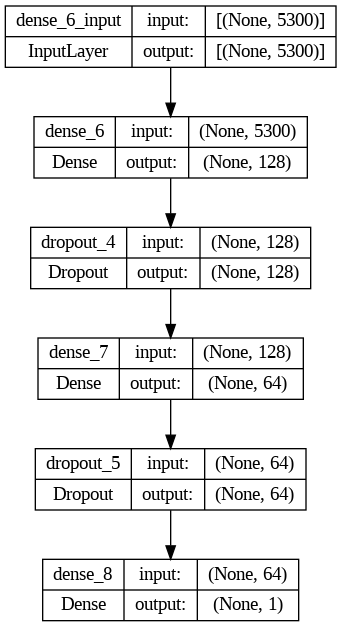

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Evaluation

## Accuracy, Precision, Recall

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

41/41 [==============================] - 0s 3ms/step
Accuracy: 0.8925556408288565
Precision: 0.52
Recall: 0.5342465753424658


## Confusion Matrix

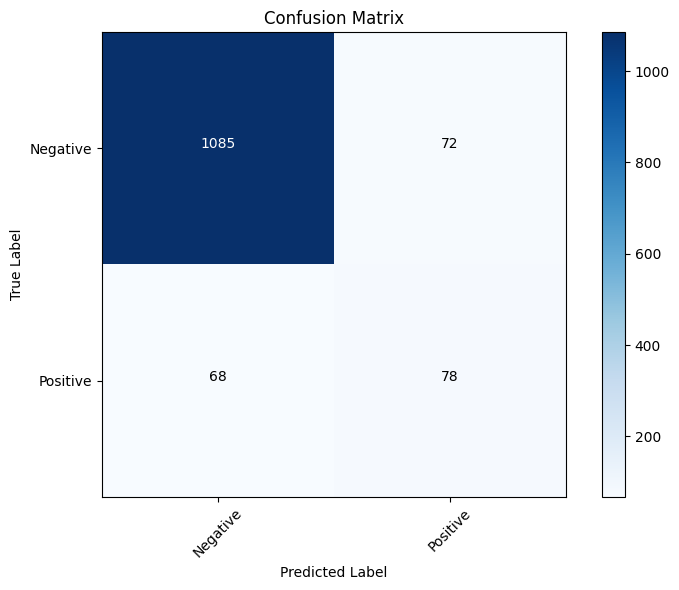

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(['Negative', 'Positive']))
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

## Model Prediction vs Actual Data

Model Loss: 0.7863
Model Accuracy: 89.26%
41/41 [==============================] - 0s 2ms/step


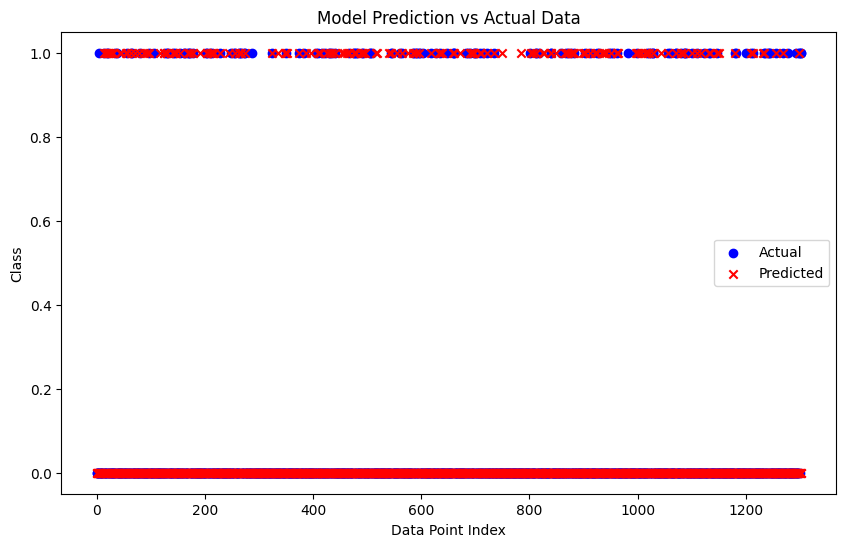

In [ ]:
import matplotlib.pyplot as plt

# Evaluasi model pada data test
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Model Loss: {loss:.4f}")
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Prediksi pada data test
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Plotting
plt.figure(figsize=(10, 6))

# Plot data aktual
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')

# Plot prediksi
plt.scatter(range(len(y_pred_classes)), y_pred_classes, color='red', marker='x', label='Predicted')

plt.title('Model Prediction vs Actual Data')
plt.xlabel('Data Point Index')
plt.ylabel('Class')
plt.legend()
plt.show()

## Model Loss and Model Accuracy

Model Loss: 0.7863
Model Accuracy: 89.26%


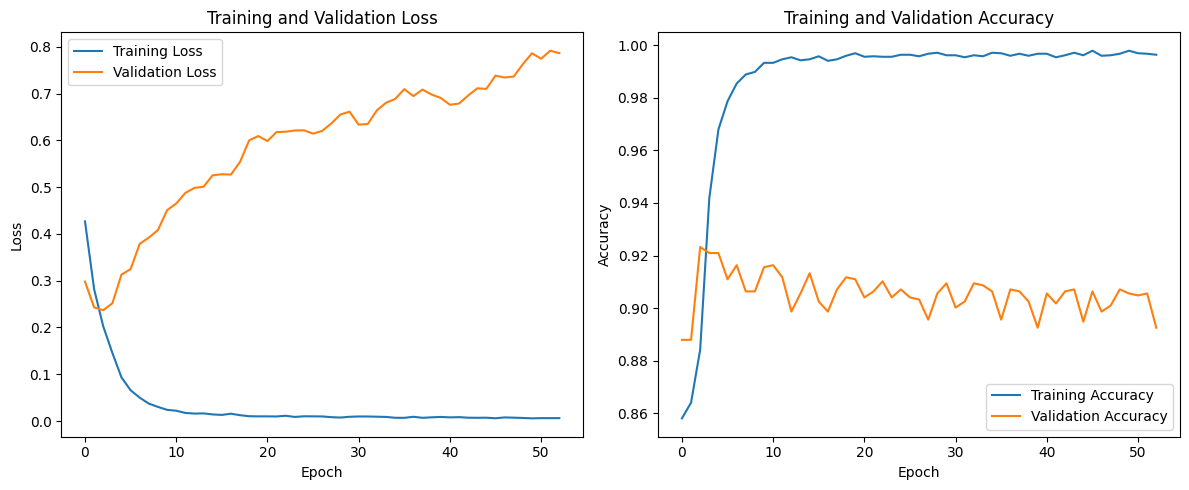

In [ ]:
# Evaluasi model pada data test
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Loss: {loss:.4f}")
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluating overfit or underfit
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Find the epoch with the minimum validation loss (best validation point)
best_epoch = validation_loss.index(min(validation_loss))

print(f"Best Validation Loss at Epoch {best_epoch + 1}")

# Check if the model is overfitting, underfitting, or optimal
if training_loss[best_epoch] < validation_loss[best_epoch]:
    print("Model is likely overfitting. The training loss is significantly lower than the validation loss, indicating that the model is memorizing the training data.")
elif training_loss[best_epoch] > validation_loss[best_epoch]:
    print("Model is likely underfitting. The training loss is higher than the validation loss, suggesting the model's inability to learn from the training data.")
else:
    print("Model is performing optimally or the determination is inconclusive. Both training and validation losses are close, indicating balanced performance.")

Best Validation Loss at Epoch 3
Model is likely overfitting. The training loss is significantly lower than the validation loss, indicating that the model is memorizing the training data.


In [ ]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.7863
Test Accuracy: 89.26%
